In [6]:
import cv2
import numpy as np
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [3]:
# create the color map

def generate_color_value_map(image_path):
    """  
    Args:
        image_path (str): Path to the color bar image.
    
    Returns:
        dict: A dictionary mapping RGB colors to corresponding values.
        KDTree: KDTree for nearest color lookup.
    """

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    #image dimensions
    height, width, _ = img.shape
    
    #sample pixels along vertical centerline of color bar
    center_x = width // 2
    colors = []
    values = np.linspace(1, 0, height)
    
    for y in range(height):
        color = img[y, center_x]
        colors.append(tuple(color))  # Convert to tuple for dictionary keys
    
    #color-to-value mapping
    color_value_map = {color: value for color, value in zip(colors, values)}
    
    # KDTree for nearest color lookup
    color_tree = KDTree(colors)
    
    return color_value_map, color_tree

def get_value_from_color(color, color_value_map, color_tree):
    """
    Retrieve the corresponding value for a given color.
    
    Args:
        color (tuple): RGB color as a tuple (e.g., (255, 0, 0)).
        color_value_map (dict): Dictionary mapping RGB colors to values.
        color_tree (KDTree): KDTree for nearest color lookup.
    
    Returns:
        float: Corresponding value in the range [0, 1].
    """
    _, idx = color_tree.query(color)  # Find the nearest color index
    nearest_color = list(color_value_map.keys())[idx]
    return color_value_map[nearest_color]

#run and save color map to .txt file
if __name__ == "__main__":

    image_path = "legenda_small.png" 
    
    color_value_map, color_tree = generate_color_value_map(image_path)
    with open("value_map.txt", "w") as output:
        output.write(str(color_value_map))


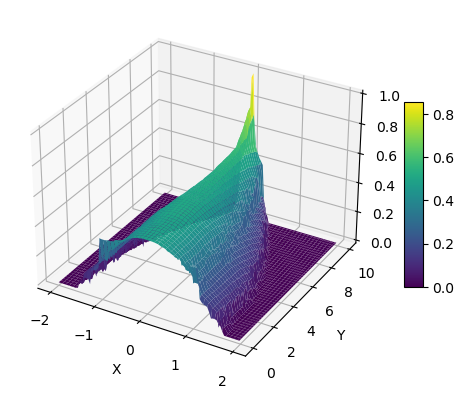

Coordinates saved to coordinates_graph_1.txt


In [12]:
# extract the data form the graph, and plot the digitized results

def pixel_to_data_coords(x_pixel, y_pixel, img_width, img_height, x_range, y_range):
    """
    Map pixel coordinates to data coordinates.
    """
    x_data = x_range[0] + (x_pixel / img_width) * (x_range[1] - x_range[0])
    y_data = y_range[0] + ((img_height - y_pixel) / img_height) * (y_range[1] - y_range[0])
    return x_data, y_data

def analyze_graph_image(image_path, color_value_map, color_tree, x_range, y_range):
    """
    Analyze a graph image and generate data points with values based on colors.

    Args:
        image_path (str): Path to the graph image.
        color_value_map (dict): Mapping of RGB colors to values.
        color_tree (KDTree): KDTree for nearest color lookup.
        x_range (tuple): (min_x, max_x) range of the x-axis.
        y_range (tuple): (min_y, max_y) range of the y-axis.

    Returns:
        np.ndarray: 3D array of x, y, and z values.
    """
    #load image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Graph image not found at {image_path}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

    #image dimensions
    height, width, _ = img.shape

    #prepare arrays
    x_vals, y_vals, z_vals = [], [], []

    # Iterate over every pixel
    for y_pixel in range(height):
        for x_pixel in range(width):
            #get the color of the pixel
            color = tuple(img[y_pixel, x_pixel])

            #find the closest value using the lookup table
            _, idx = color_tree.query(color)
            if idx >= len(color_value_map):
                #assign NaN or default value if color not found
                value = float(0) 
            else:
                nearest_color = list(color_value_map.keys())[idx]
                value = color_value_map[nearest_color]

            #map pixel to data coordinates
            x_data, y_data = pixel_to_data_coords(
                x_pixel, y_pixel, width, height, x_range, y_range
            )

            #store the data point
            x_vals.append(x_data)
            y_vals.append(y_data)
            z_vals.append(value)
            
    return np.array(x_vals), np.array(y_vals), np.array(z_vals)

#optional plot
def plot_3d_surface(x_vals, y_vals, z_vals):
    """
    Plot a 3D surface based on x, y, and z values.

    Args:
        x_vals (np.ndarray): Array of x values.
        y_vals (np.ndarray): Array of y values.
        z_vals (np.ndarray): Array of z values.
    """
    #grid for interpolation
    grid_x, grid_y = np.mgrid[
        np.min(x_vals):np.max(x_vals):100j, 
        np.min(y_vals):np.max(y_vals):100j
    ]

    #interpolate z values
    grid_z = griddata(
        points=(x_vals, y_vals),  #input points (x, y)
        values=z_vals,           #corresponding z values
        xi=(grid_x, grid_y),     #grid to interpolate onto
        method='linear'          #interpolation method (linear,nearest,cubic)
    )

    #Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    #surface plot
    surf = ax.plot_surface(
        grid_x, grid_y, grid_z, cmap="viridis", edgecolor='none'
    )
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()


def save_coordinates_to_txt(x_vals, y_vals, z_vals, filename="coordinates.txt"):
    """
    Save (x, y, z) coordinates to a text file seperated by \tab.

    Args:
        x_vals (np.ndarray): Array of x values.
        y_vals (np.ndarray): Array of y values.
        z_vals (np.ndarray): Array of z values.
        filename (str): Name of the output text file.
    """
    with open(filename, "w") as file:
        file.write("X	Y	Z\n")  # Header
        for x, y, z in zip(x_vals, y_vals, z_vals):
            file.write(f"{x}\t{y}\t{z}\n")
    print(f"Coordinates saved to {filename}")




if __name__ == "__main__":

    graph_image_path = "graph_3_half.png" 

    # Axis ranges of the graph
    x_range = (-2, 2) 
    y_range = (10, 0)  #(0 at top, 10 at bottom)

    # Analyze the graph image
    x_vals, y_vals, z_vals = analyze_graph_image(graph_image_path, color_value_map, color_tree, x_range, y_range)

    # Plot the 3D graph
    plot_3d_surface(x_vals, y_vals, z_vals)

    #save as coordinates
    save_coordinates_to_txt(x_vals, y_vals, z_vals, "coordinates_graph_1.txt")
